## Facial Expression Recognition with Keras

 In this script, I have implemented Facial Expression Recognition using Keras. I was able to achieve a validation accuracy of 0.63, which is slightly higher than 2013 state of the art model for the same application

### Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesTensorFlowKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.1.0


### Plot Sample Image

Now we will plot a few sample images of our dataset

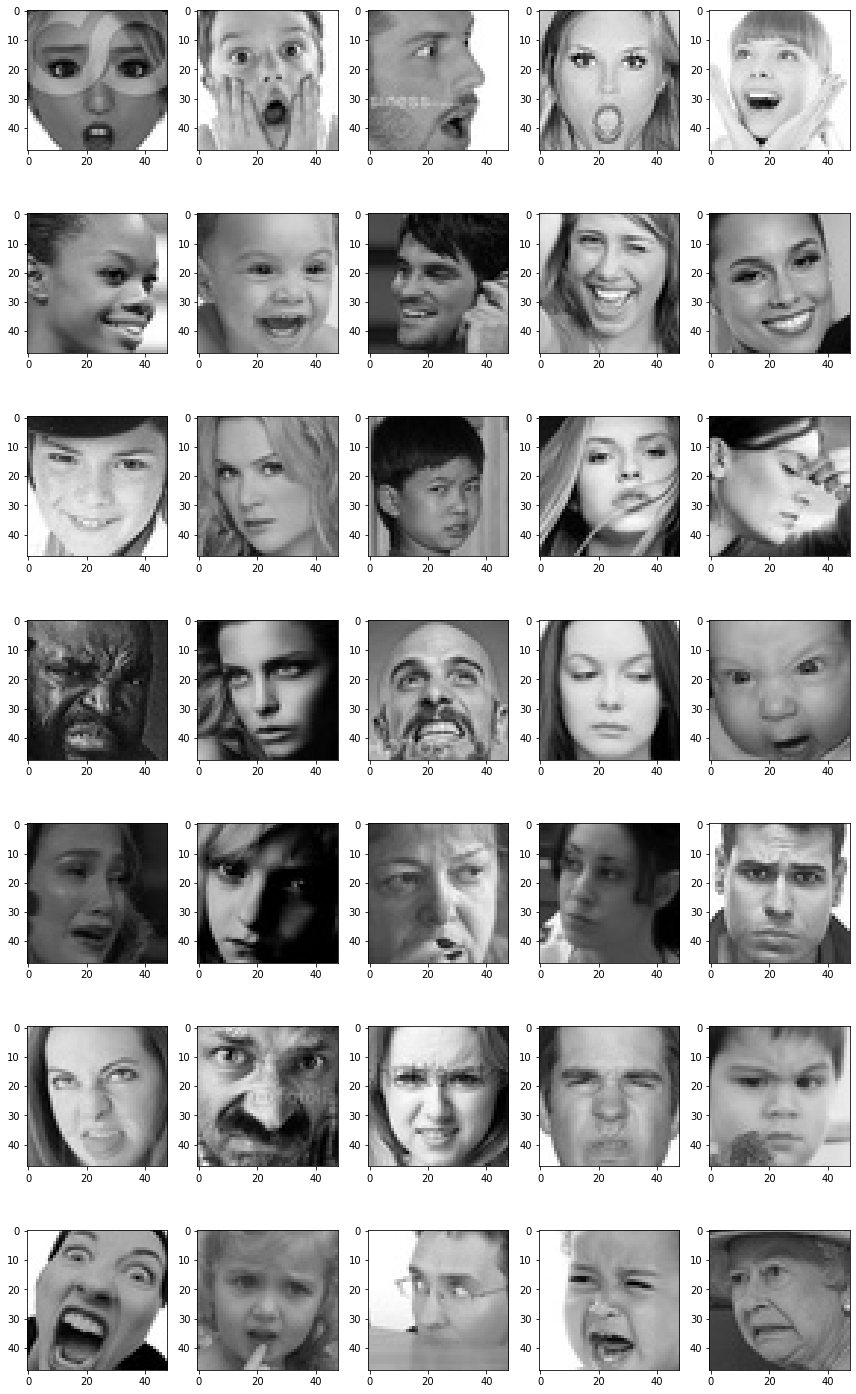

In [2]:
utils.datasets.fer.plot_example_images(plt).show()

In [3]:
#Now, let us understand if we have a class imbalance problem
#So, we look at a number of each type of emotion records in the dataset

for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

3171 surprise images
7215 happy images
4965 neutral images
3995 angry images
4830 sad images
436 disgust images
4097 fear images


We see that there is class imbalance here, so we will remove it ahead in our code by data augmentation method

Reason :  In business context, class imbalance can misclassify the more important class which needs to be classified correctly. Hence, it is absolutely essential for our algorithm to have roughly the same number of records of each classification class which training and validation.

Additionally, validation and test datasets need to have the same distribution. If they do not have the same distribution, we will not get a consistent accuracy/error percentage and may conclude that our model has high variance/bias when it actually needs more data of a minority class.

### Generate Training and Validation Batches

In [4]:
img_size = 48
batch_size = 64 #(power of 2 to speed up the training process)

#Creatingn a data generator object(since we need to augment data to nullify class imbalance)
datagen_train = ImageDataGenerator(horizontal_flip = True) # horiz_flip -> boolean (randomly
#flips images along the horizontal axis)
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size = (img_size,img_size),
                                                    color_mode = 'grayscale',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical', # classification
                                                    shuffle = True
                                                   
                                                   )

Found 28709 images belonging to 7 classes.


In [5]:
#Data generator for the validation set

#Creatingn a data generator object(since we need to augment data to nullify class imbalance)
datagen_validation = ImageDataGenerator(horizontal_flip = True) # horiz_flip -> boolean (randomly
#flips images along the horizontal axis)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                    color_mode = 'grayscale',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical', # classification (one hot encoding)
                                                    shuffle = False # we don't want to shuffle here
                                                   
                                                   )

Found 7178 images belonging to 7 classes.


### Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

Initialising our CNN

In [24]:
model = Sequential()

#1st Conv Block:
#padding = same : so that we don't lose information about the image
#Each neuron has its own (3 by 3) filter, and we have 64 such neurons
model.add(Conv2D(64,(3,3),padding = 'same', input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2))) # size to which our input is reduced -> (2,2)
model.add(Dropout(0.25)) # Beta = 0.25(hyperparameter for Dropout to avoid overfitting)

#2nd Conv Block
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2))) 
model.add(Dropout(0.25)) 

#3rd Conv Block
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2))) 
model.add(Dropout(0.25)) 

#4th Conv Block
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2))) 
model.add(Dropout(0.25)) 

#Now, we flatten our output to pass to our fully connected layers
model.add(Flatten())

#Fully Connected Layers:
#1st
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25)) 

#2nd
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25)) 

#Last Dense Layer 
model.add(Dense(7,activation='softmax')) #We use softmax, because we have multi-class 
                                        #classification to do and eventually 
                                        #convert the probabilities of the softmax output
                                         #to 1 or 0
opt = Adam(lr = 0.00035) #learning rate = hyperparameter
model.compile(optimizer=opt,loss = 'categorical_crossentropy',
             metrics = ['accuracy']) # multiclass classification
model.summary()





Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 24, 128)      

Interesting Fact : We have 4.5 million parameters to learn :P

### Train and Evaluate Model

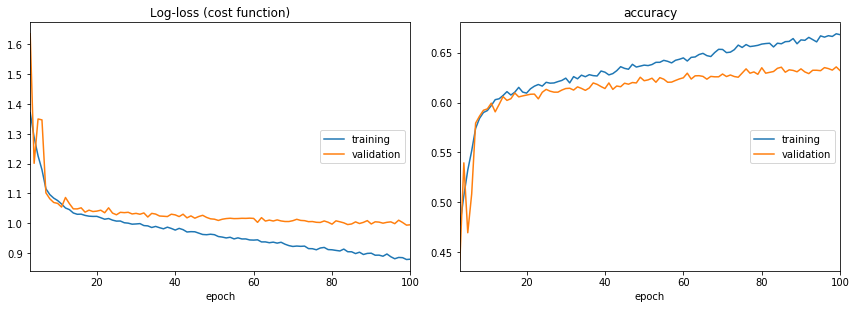

Log-loss (cost function):
training   (min:    0.879, max:    1.816, cur:    0.880)
validation (min:    0.994, max:    1.693, cur:    0.995)

accuracy:
training   (min:    0.302, max:    0.669, cur:    0.668)
validation (min:    0.359, max:    0.636, cur:    0.632)

Epoch 00100: saving model to model_weights.h5
448/448 [==============================] - 27s 61ms/step - loss: 0.8797 - accuracy: 0.6678 - val_loss: 0.9952 - val_accuracy: 0.6318


In [25]:
epochs = 100
#mini-batch where each batch is of size 64 images(for both train and val)
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size


#Defining Callbacks -> to monitor metrics and save the model with good metric values
#Goal : Save model weights with "max" "val_accuracy"
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode = 'max',
                             verbose = 1
                            ) # val_accuracy instead of earlier "val_acc"
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.1,patience = 2, 
min_lr = 0.00001,mode = 'auto')
# Here, we reduce our learning rate if we don't see an improvement
#in our validation loss over 2 epochs, this is because we want to eventually reach the global minimum and
#not local minimum, thus, we need to implement learning rate decay

callbacks = [PlotLossesTensorFlowKeras(),checkpoint, reduce_lr]

#Our history object will return all information like val_acc, val_loss, etc
history = model.fit(x = train_generator,steps_per_epoch = steps_per_epoch,
epochs = epochs, validation_data = validation_generator,
validation_steps = validation_steps, callbacks = callbacks
)

In [20]:
# We see that the validation accuracy is 0.6318, this is higher than the 2013 state of the 
#art model for the same purpose

### Represent Model as JSON String

In [26]:
model_json = model.to_json() # information about the layers and their ordering
with open("model.json","w") as json_file:
    json_file.write(model_json)